# 파일 업로드
1. 왼쪽에 폴더 모양 버튼을 누른다
  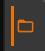
2. 파일 업로드 버튼을 누른다. 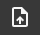
3. 제공된 데이터 csv 파일들을 업로드 한다.
----
* 참고사항: 이 과정은 코랩을 새로고침 할 때 마다 해주어야 함. (정확히는 런타임이 다시 실행 될 때 마다)

# 데이터 전처리

In [ ]:
import pandas as pd
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# 데이터셋 불러오기
dataset_train = pd.read_csv('new_weather_data_train.csv', index_col=0)
dataset_train

,month,day,hour,temperature,temperature_dew_point,relative_humidity,wind_speed,visibility,pressure,weather
0,1,1,0,-1.8,-3.9,86,4,8.0,101.24,2
1,1,1,1,-1.8,-3.7,87,4,8.0,101.24,2
2,1,1,2,-1.8,-3.4,89,7,4.0,101.26,0
3,1,1,3,-1.5,-3.2,88,6,4.0,101.27,0
4,1,1,4,-1.5,-3.3,88,7,4.8,101.23,2
...,...,...,...,...,...,...,...,...,...,...
7022,10,19,14,13.0,12.1,94,15,8.0,100.55,0
7023,10,19,15,13.3,12.1,92,13,9.7,100.45,0
7024,10,19,16,12.9,12.3,96,7,3.2,100.45,0
7025,10,19,17,13.1,12.1,94,17,6.4,100.38,0


In [ ]:
# 데이터셋 정보 확인
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7027 entries, 0 to 7026
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  7027 non-null   int64  
 1   day                    7027 non-null   int64  
 2   hour                   7027 non-null   int64  
 3   temperature            7027 non-null   float64
 4   temperature_dew_point  7027 non-null   float64
 5   relative_humidity      7027 non-null   int64  
 6   wind_speed             7027 non-null   int64  
 7   visibility             7027 non-null   float64
 8   pressure               7027 non-null   float64
 9   weather                7027 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 603.9 KB


Feature 데이터와 Target 데이터를 분리
* Feature: Target 데이터를 예측하기 위한 데이터 속성
* Target: 예측 해야하는 데이터. 여기서는 총 22가지의 카테고리 데이터

In [ ]:
# Feature 데이터 분리
dataset_train_x = dataset_train.drop(['weather'], axis=1)
dataset_train_x

,month,day,hour,temperature,temperature_dew_point,relative_humidity,wind_speed,visibility,pressure
0,1,1,0,-1.8,-3.9,86,4,8.0,101.24
1,1,1,1,-1.8,-3.7,87,4,8.0,101.24
2,1,1,2,-1.8,-3.4,89,7,4.0,101.26
3,1,1,3,-1.5,-3.2,88,6,4.0,101.27
4,1,1,4,-1.5,-3.3,88,7,4.8,101.23
...,...,...,...,...,...,...,...,...,...
7022,10,19,14,13.0,12.1,94,15,8.0,100.55
7023,10,19,15,13.3,12.1,92,13,9.7,100.45
7024,10,19,16,12.9,12.3,96,7,3.2,100.45
7025,10,19,17,13.1,12.1,94,17,6.4,100.38


In [ ]:
# Target 데이터 분리
dataset_train_y = dataset_train[['weather']]
dataset_train_y

,weather
0,2
1,2
2,0
3,0
4,2
...,...
7022,0
7023,0
7024,0
7025,0


target 데이터를 원핫 인코딩으로 컴퓨터가 학습하기 좋은 형태로 변형.
* 원 핫 인코딩
  * 숫자로 표현된 카테고리 데이터를 0과 1로 바꾸는 작업.  
    예) 1, 3, 2 -> [1, 0, 0], [0, 0, 1], [0, 1, 0]
  * 일반 숫자는 크기에 따라 중요도를 학습 할 수 있으므로, 해당하는 카테고리에만 1을 주어 잘못된 방향으로 학습하는걸 방지.

In [ ]:
from tensorflow.keras.utils import to_categorical
dataset_train_y = to_categorical(dataset_train_y)
dataset_train_y

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

**추가된 부분**
* 각 데이터를 12시간 이전 데이터까지 포함시킴
* 최근 12시간 날씨 데이터를 활용하여 날씨 예측의 정확도를 높이는 과정

In [ ]:
# 하나의 라벨에 최근 12개의 데이터씩 묶어주는 작업
# 12시간 전 데이터부터 현재 데이터까지 학습에 활용
import numpy as np
train_x = np.zeros((len(dataset_train_x) - 12, 12, 9))
for i in range(len(dataset_train_x) - 12):
  x = dataset_train_x.iloc[i:i + 12, :].values
  train_x[i,:, :] = x
train_x.shape

(7015, 12, 9)

In [ ]:
# 날씨 예측할떄 최근 12시간 로그를 활용하므로 맨 앞 11시간 라벨은 활용할 수 없음
# 맨 앞 11시간 데이터는 12개씩 묶어줄 수 없기 때문
# 12번째 라벨부터 학습에 사용하도록 변경
train_y = dataset_train_y[12:,:]
train_y.shape

(7015, 5)

In [ ]:
# 테스트 데이터는 feature 데이터만 존재
dataset_test_x = pd.read_csv('new_weather_data_test_x.csv', index_col=0)
dataset_test_x

,month,day,hour,temperature,temperature_dew_point,relative_humidity,wind_speed,visibility,pressure
7027,10,19,19,13.5,12.4,93,7,9.7,100.29
7028,10,19,20,13.8,12.9,94,19,12.9,100.13
7029,10,19,21,13.8,12.6,92,17,24.1,100.16
7030,10,19,22,13.4,12.3,93,7,16.1,100.15
7031,10,19,23,13.5,12.3,92,11,16.1,100.10
...,...,...,...,...,...,...,...,...,...
8779,12,31,19,0.1,-2.7,81,30,9.7,100.13
8780,12,31,20,0.2,-2.4,83,24,9.7,100.03
8781,12,31,21,-0.5,-1.5,93,28,4.8,99.95
8782,12,31,22,-0.2,-1.8,89,28,9.7,99.91


In [ ]:
# 하나의 라벨에 최근 12개의 데이터씩 묶어주는 작업
# Test 데이터는 모든 데이터를 예측해야 하므로
# 맨 앞 12시간 전 데이터 까지는 빈 부분은 모두 0으로 채움
import numpy as np
test_x = np.zeros((len(dataset_test_x), 12, 9))
for i in range(1, len(dataset_test_x) + 1):
  x = np.zeros((12, 9))
  insert_data = dataset_test_x.iloc[(i - 12 if i - 12 > 0 else 0):i, :].values
  x[12 - len(insert_data):12,:] = insert_data
  test_x[i - 1,:, :] = x
test_x.shape

(1757, 12, 9)

In [ ]:
from keras import backend as K
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    return _f1score

In [ ]:
# 모델을 구성할 라이브어리 임포트
import tensorflow.keras.layers as layer
from tensorflow.keras.models import Sequential


In [ ]:
# 모델 작성
# 모델을 계속 바꿔보며 학습하시고 학습 결과를 제출하시면 됩니다.

model = Sequential()
with strategy.scope(): model.add(layer.Input(shape=(12, 9,))) # 가장 첫 레이어는 반드시 units=9
with strategy.scope(): model.add(layer.LSTM(units=64))
with strategy.scope(): model.add(layer.Dropout(0.3))
with strategy.scope(): model.add(layer.Dense(units=5, activation='softmax')) # 가장 마지막 레이어는 반드시 units=5, activation='softmax'

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
# 모델 컴파일
with strategy.scope(): model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=[f1score])

In [ ]:
# model.summary()

In [ ]:
# 학습
# ephocs=학습 방법 횟수. ephocs의 값을 바꾸면 정확도가 더욱 좋아지기도 함.
with strategy.scope():model.fit(train_x, train_y, epochs=70, batch_size=64)

Epoch 1/70
110/110 [==============================] - 7s 24ms/step - loss: 1.1298 - f1score: 0.2860
Epoch 2/70
110/110 [==============================] - 2s 17ms/step - loss: 0.9464 - f1score: 0.4500
Epoch 3/70
110/110 [==============================] - 2s 17ms/step - loss: 0.9051 - f1score: 0.4955
Epoch 4/70
110/110 [==============================] - 2s 17ms/step - loss: 0.8820 - f1score: 0.5212
Epoch 5/70
110/110 [==============================] - 2s 17ms/step - loss: 0.8718 - f1score: 0.5383
Epoch 6/70
110/110 [==============================] - 2s 17ms/step - loss: 0.8565 - f1score: 0.5436
Epoch 7/70
110/110 [==============================] - 2s 17ms/step - loss: 0.8496 - f1score: 0.5562
Epoch 8/70
110/110 [==============================] - 2s 16ms/step - loss: 0.8459 - f1score: 0.5611
Epoch 9/70
110/110 [==============================] - 2s 17ms/step - loss: 0.8306 - f1score: 0.5713
Epoch 10/70
110/110 [==============================] - 2s 18ms/step - loss: 0.8228 - f1score: 0.5780

In [ ]:
# 날씨 예측
import numpy as np
pre_data = pd.DataFrame({'weather': np.argmax(model.predict(test_x), axis=1)})
pre_data

55/55 [==============================] - 1s 8ms/step


,weather
0,0
1,0
2,2
3,2
4,2
...,...
1752,2
1753,2
1754,1
1755,1


In [ ]:
# 예측 데이터 저장
# 저장된 파일을 제출하시면 됩니다.
pre_data.to_csv('submission_lstm2.csv')